In [1]:
!pip install -q transformers[sentencepiece]
!pip install -q datasets
!pip install -q sacrebleu
!pip uninstall -y tqdm
!pip install -q tqdm==4.43.0 

     |████████████████████████████████| 2.6 MB 7.4 MB/s 
     |████████████████████████████████| 636 kB 64.3 MB/s 
     |████████████████████████████████| 895 kB 70.7 MB/s 
     |████████████████████████████████| 3.3 MB 56.9 MB/s 
     |████████████████████████████████| 1.1 MB 58.4 MB/s 
     |████████████████████████████████| 264 kB 9.2 MB/s 
     |████████████████████████████████| 118 kB 15.5 MB/s 
     |████████████████████████████████| 243 kB 17.2 MB/s 
     |████████████████████████████████| 76 kB 5.6 MB/s 
     |████████████████████████████████| 54 kB 2.7 MB/s 
Found existing installation: tqdm 4.62.0
Uninstalling tqdm-4.62.0:
  Successfully uninstalled tqdm-4.62.0
     |████████████████████████████████| 59 kB 4.3 MB/s 


In [2]:
!gdown https://drive.google.com/uc?id=18NmpZ8BWWMEWlmSCacLDOKcGaz-qHoOg

Downloading...
From: https://drive.google.com/uc?id=18NmpZ8BWWMEWlmSCacLDOKcGaz-qHoOg
To: /content/Dutch.xlsx
14.3MB [00:00, 30.9MB/s]


In [3]:
import pandas as pd
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt
from datasets import Dataset,load_metric
from sklearn.model_selection import train_test_split
import torch
from tqdm.auto import tqdm
from transformers import MarianConfig,MarianMTModel,MarianTokenizer,DataCollatorForSeq2Seq,AdamW
checkpoint = 'Helsinki-NLP/opus-mt-en-nl'

In [4]:
df = pd.read_excel('/content/Dutch.xlsx')
df.head()

,English,Dutch
0,Resumption of the session,Hervatting van de zitting
1,I declare resumed the session of the European ...,Ik verklaar de zitting van het Europees Parlem...
2,"Although, as you will have seen, the dreaded '...","Zoals u heeft kunnen constateren, is de grote ..."
3,You have requested a debate on this subject in...,U heeft aangegeven dat u deze vergaderperiode ...
4,"In the meantime, I should like to observe a mi...",Nu wil ik graag op verzoek van een aantal coll...


In [5]:
df.isnull().sum()

English    1393
Dutch       121
dtype: int64

In [6]:
df.dropna(axis = 0,inplace=True)
df.reset_index(inplace=True)
df.drop('index',axis = 1,inplace=True)

In [7]:
df.head()

,English,Dutch
0,Resumption of the session,Hervatting van de zitting
1,I declare resumed the session of the European ...,Ik verklaar de zitting van het Europees Parlem...
2,"Although, as you will have seen, the dreaded '...","Zoals u heeft kunnen constateren, is de grote ..."
3,You have requested a debate on this subject in...,U heeft aangegeven dat u deze vergaderperiode ...
4,"In the meantime, I should like to observe a mi...",Nu wil ik graag op verzoek van een aantal coll...


In [8]:
train_df,val_df = train_test_split(df,random_state = 42,test_size = 0.2)

In [9]:
print(train_df.shape)
print(val_df.shape)

(78788, 2)
(19698, 2)


In [10]:
#Hyperparameters
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
max_length = 512
batch_size = 8
learning_rate = 1e-5

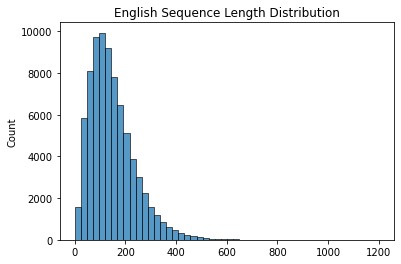

In [11]:
length_list = []
for i in train_df.English:
  length_list.append(len(i))
sns.histplot(length_list,bins = 50)
plt.title('English Sequence Length Distribution')
plt.show()

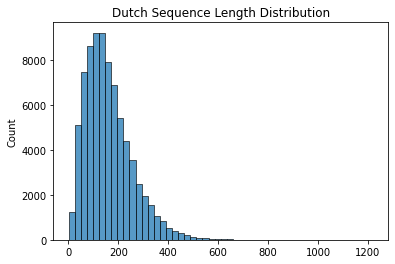

In [12]:
length_list = []
for i in train_df.Dutch:
  length_list.append(len(i))
sns.histplot(length_list,bins = 50)
plt.title('Dutch Sequence Length Distribution')
plt.show()

In [13]:
train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)
train_dataset = train_dataset.remove_columns(['__index_level_0__'])
val_dataset = val_dataset.remove_columns(['__index_level_0__'])
print(train_dataset)
print(val_dataset)

Dataset({
    features: ['English', 'Dutch'],
    num_rows: 78788
})
Dataset({
    features: ['English', 'Dutch'],
    num_rows: 19698
})


In [14]:
tokenizer = MarianTokenizer.from_pretrained(checkpoint)
tokenizer

PreTrainedTokenizer(name_or_path='Helsinki-NLP/opus-mt-en-nl', vocab_size=67028, model_max_len=512, is_fast=False, padding_side='right', special_tokens={'eos_token': '</s>', 'unk_token': '<unk>', 'pad_token': '<pad>'})

In [15]:
model = MarianMTModel.from_pretrained(checkpoint)
model.config.pad_token_id

67027

In [16]:
def preprocess(examples,MAX_LENGTH = 512):
  model_inputs = tokenizer(examples['English'],
                           max_length=MAX_LENGTH,
                           padding = 'max_length',
                           truncation=True,
                           return_attention_mask = True)
  with tokenizer.as_target_tokenizer():
    targets = tokenizer(examples['Dutch'],
                        max_length=MAX_LENGTH,
                        padding='max_length',
                        truncation=True,
                        return_attention_mask=True)
  model_inputs['labels'] = targets['input_ids']
  model_inputs['decoder_input_ids'] = targets['input_ids']
  model_inputs['decoder_attention_mask'] = targets['attention_mask']
  return model_inputs

In [17]:
train_inputs = train_dataset.map(preprocess,batched = True)
val_inputs = val_dataset.map(preprocess,batched = True)
train_inputs = train_inputs.remove_columns(['English','Dutch'])
val_inputs = val_inputs.remove_columns(['English','Dutch'])

In [18]:
data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer,
                                       max_length=512,
                                       model = model)

In [19]:
train_dataloader = torch.utils.data.DataLoader(train_inputs,
                                               batch_size = batch_size,
                                               shuffle = True,
                                               collate_fn = data_collator)
val_dataloader = torch.utils.data.DataLoader(val_inputs,
                                             batch_size = batch_size,
                                             shuffle = False,
                                             collate_fn = data_collator)

In [20]:
for batch in train_dataloader:
  break
batch['labels'][batch['labels']==67027] = -100
print(batch['labels'])

tensor([[  535,   141,    88,  ...,  -100,  -100,  -100],
        [  535,   179,  6249,  ...,  -100,  -100,  -100],
        [  245,  6557, 23232,  ...,  -100,  -100,  -100],
        ...,
        [ 1591, 31639,     6,  ...,  -100,  -100,  -100],
        [   48,   123,   444,  ...,  -100,  -100,  -100],
        [   70,   414,     3,  ...,  -100,  -100,  -100]])


In [45]:
# model.to(device)
# outputs = model(**batch)
# print(outputs.logits.shape)
# print(outputs.loss)
# output = torch.argmax(outputs.logits,dim =-1)
# tokenizer.batch_decode(output)

In [22]:
num_epochs = 2
num_training_steps = num_epochs * len(train_dataloader)
print(num_training_steps)

19698


In [23]:
optimizer = AdamW(model.parameters(),lr = learning_rate)

In [24]:
model.to(device)
progress_bar = tqdm(range(num_training_steps))
model.train()
for epoch in range(num_epochs):
  epoch_loss = 0.0
  run_loss = 0.0
  for batch in train_dataloader:
    batch['labels'][batch['labels']==67027] = -100
    batch = {k: v.to(device) for k, v in batch.items()}
    outputs = model(**batch)
    loss = outputs.loss
    run_loss += loss 
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    progress_bar.update(1)
  epoch_loss = run_loss/len(train_dataloader)
  print(100*'-')
  print('Epoch:{}====>Loss:{:.4f}'.format(epoch+1,epoch_loss))

----------------------------------------------------------------------------------------------------
Epoch:1====>Loss:1.6144
----------------------------------------------------------------------------------------------------
Epoch:2====>Loss:1.5111


In [25]:
!sudo apt-get install git-lfs

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  git-lfs
0 upgraded, 1 newly installed, 0 to remove and 40 not upgraded.
Need to get 2,129 kB of archives.
After this operation, 7,662 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 git-lfs amd64 2.3.4-1 [2,129 kB]
Fetched 2,129 kB in 1s (1,507 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package git-lfs.
(Reading database ... 160837 files and directories c

In [29]:
!transformers-cli repo create en-to-dutch-marianmt

2021-07-31 12:42:52.050182: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
/usr/local/lib/python3.7/dist-packages/transformers/commands/user.py:269: UserWarning: Managing repositories through transformers-cli is deprecated. Please use `huggingface-cli` instead.
  "Managing repositories through transformers-cli is deprecated. Please use `huggingface-cli` instead."
git version 2.17.1
Error: unknown flag: --version

Sorry, no usage text found for "git-lfs"

You are about to create vvn/en-to-dutch-marianmt
Proceed? [Y/n] y

Your repo now lives at:
  https://huggingface.co/vvn/en-to-dutch-marianmt

You can clone it locally with the command below, and commit/push as usual.

  git clone https://huggingface.co/vvn/en-to-dutch-marianmt



In [30]:
!git lfs install

Error: Failed to call git rev-parse --git-dir --show-toplevel: "fatal: not a git repository (or any of the parent directories): .git\n"
Git LFS initialized.


In [34]:
model.save_pretrained('vvn/en-to-dutch-marianmt',push_to_hub=True)

In [35]:
tokenizer.save_pretrained('vvn/en-to-dutch-marianmt',push_to_hub=True)

('vvn/en-to-dutch-marianmt/tokenizer_config.json',
 'vvn/en-to-dutch-marianmt/special_tokens_map.json',
 PosixPath('vvn/en-to-dutch-marianmt/source_spm'),
 PosixPath('vvn/en-to-dutch-marianmt/target_spm'),
 PosixPath('vvn/en-to-dutch-marianmt/vocab'),
 PosixPath('vvn/en-to-dutch-marianmt/tokenizer_config_file'),
 'vvn/en-to-dutch-marianmt/added_tokens.json')